# Profile Bayesian Modeling Comparison

This notebook tries various Bayesian models for analyzing the underlying user profiles, *not* the recommendation lists.

The main `ProfileModel` notebook uses our selected model, described in more detail in [the PDF file](models.pdf), to generate a clean set of plots.

## Setup

In [1]:
library(rstan)
library(loo)
library(iterators)
library(foreach)
library(assertthat)
library(tidyverse)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
This is loo version 1.1.0
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
accumulate(): purrr, foreach
extract():    tidyr, rstan
filter():     dplyr, stats
has_name():   tibble, assertthat
lag():        dplyr, stats
when():       purrr, foreach


In [2]:
library(doParallel)
registerDoParallel()
options(mc.cores=parallel::detectCores())
rstan_options(auto_write=TRUE)

Loading required package: parallel


In [3]:
options(repr.matrix.max.rows=20)
options(repr.plot.height=5,
        repr.plot.width=10)

In [4]:
source("utils.R")

## Load User Profiles and Background Data

We have author-gender information for a bunch of books:

In [5]:
author_gender = read_csv("build/author-gender.csv")
head(author_gender)

Parsed with column specification:
cols(
  bookID = col_integer(),
  authorID = col_integer(),
  authorName = col_character(),
  authorGender = col_character()
)


bookID,authorID,authorName,authorGender
10,10737183,Margaret Maron,female
19,7355012,Serge Humpich,male
46,9991626,John Peel,male
151,13426711,Russell Herman Conwell,male
181,7451186,Brody Neuenschwander,male
196,9097949,Peter Brandvold,male


Load the implicit ratings for the implicit feedback user sample.

In [11]:
bx_implicit_ratings = read_csv("build/sample-ratings-implicit.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


Load the explicit ratings for the explicit feedback user sample;

In [12]:
bx_explicit_ratings = read_csv("build/sample-ratings-explicit.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


Load the explicit ratings for the explicit feedback user sample of Amazon data

In [13]:
az_explicit_ratings = read_csv("build/sample-ratings-amazon.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


And merge them together

In [14]:
user_ratings =
    bind_rows(`BX Implicit` = bx_implicit_ratings,
              `BX Explicit` = bx_explicit_ratings,
              `AZ Explicit` = az_explicit_ratings,
              .id="Set")

For context, summarize the entire rating database.

In [10]:
bx_item_stats = read_csv("build/bx-implicit.csv") %>%
    mutate(rating=na_if(rating, 0)) %>%
    group_by(bookID) %>%
    summarize(Count=n(),
              RateCount=sum(rating > 0),
              MeanRating=mean(rating, na.rm = TRUE)) %>%
    ungroup()
bx_item_stats

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


Summarize the entire Amazon ratings

In [ ]:
az_item_stats = read_csv("build/az-ratings.csv", col_types = 'iid') %>%
    mutate(rating=na_if(rating, 0)) %>%
    group_by(bookID) %>%
    summarize(Count=n(),
              RateCount=sum(rating > 0),
              MeanRating=mean(rating, na.rm = TRUE)) %>%
    ungroup()
az_item_stats

## Summarize User Profiles

We will integrate user ratings with book information and summarize, so we can start to see what things look like.

In [15]:
user_books = user_ratings %>%
    left_join(author_gender) %>%
    mutate(authorGender = if_else(is.na(authorGender), 'unlinked', authorGender)) %>%
    transmute(Set = as.factor(Set),
              userID = userID, bookID = bookID, rating=rating,
              name=authorName,
              gender=ordered(authorGender, levels=c("female", "male",
                                                    "ambiguous", "unknown", "unlinked")))
user_books %>%
    select(Set, gender) %>%
    summary()

Joining, by = "bookID"


          Set              gender     
 AZ Explicit:32116   female   :30818  
 BX Explicit:25206   male     :40213  
 BX Implicit:49716   ambiguous:  550  
                     unknown  :12684  
                     unlinked :22773  

In [16]:
profile_info = user_books %>%
    group_by(Set, userID) %>%
    summarize(count=n(),
              linked=sum(gender != 'unlinked'),
              ambiguous = sum(gender == 'ambiguous'),
              NMale = sum(gender == 'male'),
              NFemale = sum(gender == 'female')) %>%
    ungroup() %>%
    mutate(known = NMale + NFemale,
           PropFemale = NFemale/known,
           PropKnown = known/count)
profile_info

Set,userID,count,linked,ambiguous,NMale,NFemale,known,PropFemale,PropKnown
AZ Explicit,4554,20,20,0,17,0,17,0.0000000,0.8500000
AZ Explicit,37368,17,15,0,6,1,7,0.1428571,0.4117647
AZ Explicit,38346,21,8,0,3,5,8,0.6250000,0.3809524
AZ Explicit,44881,29,14,1,4,7,11,0.6363636,0.3793103
AZ Explicit,49484,7,7,0,3,3,6,0.5000000,0.8571429
AZ Explicit,59391,13,8,0,4,1,5,0.2000000,0.3846154
AZ Explicit,69299,21,13,0,12,0,12,0.0000000,0.5714286
AZ Explicit,77417,19,17,0,6,3,9,0.3333333,0.4736842
AZ Explicit,77429,190,184,1,14,47,61,0.7704918,0.3210526
AZ Explicit,85349,30,11,0,7,3,10,0.3000000,0.3333333


### Link Coverage

What is the coverage over _distinct rated books_?

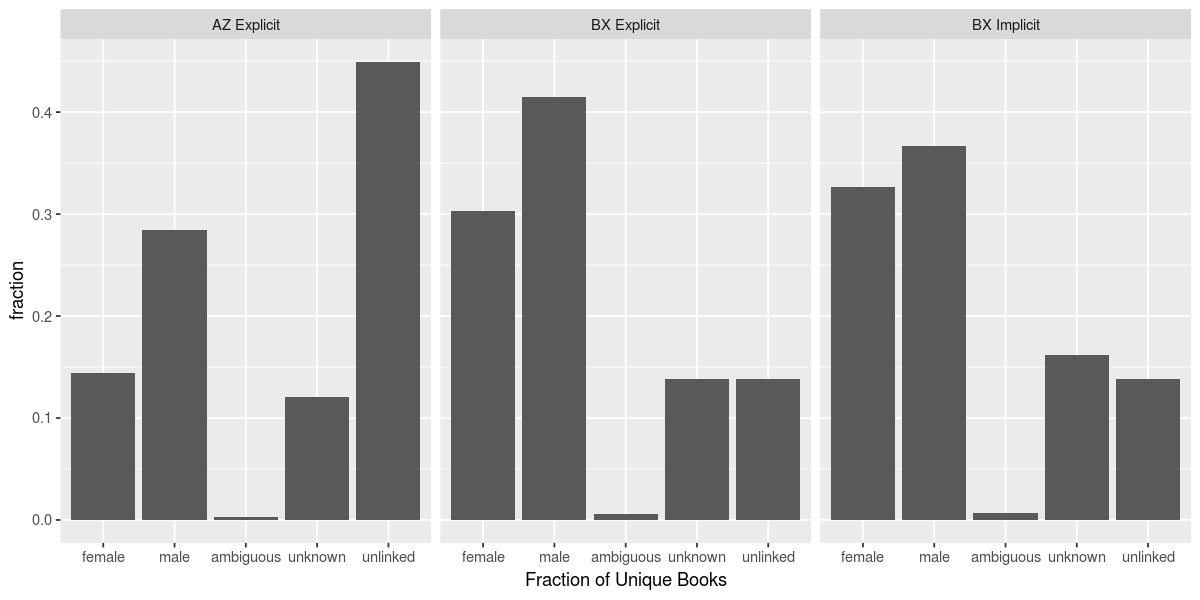

In [17]:
book_coverage = user_books %>%
    select(Set, bookID, gender) %>%
    distinct() %>%
    group_by(Set, gender) %>%
    summarize(count=n()) %>%
    group_by(Set) %>%
    mutate(fraction=count / sum(count))
ggplot(book_coverage) +
    aes(x=gender, y=fraction) +
    geom_bar(stat='identity') +
    facet_grid(~ Set) +
    xlab('Fraction of Unique Books')

In [18]:
book_coverage %>%
    select(Set, gender, fraction) %>%
    spread(Set, fraction)

gender,AZ Explicit,BX Explicit,BX Implicit
female,0.143758277,0.303250067,0.32626950
male,0.283892103,0.415149073,0.36694250
ambiguous,0.002927441,0.005694333,0.00641241
unknown,0.120234195,0.137845823,0.16214236
unlinked,0.449187984,0.138060704,0.13823323


Analyze in what we need to know:

In [19]:
book_coverage %>%
    select(Set, gender, fraction) %>%
    spread(gender, fraction) %>%
    transmute(known=female + male, unknown=unknown+unlinked, ambiguous=ambiguous)

Adding missing grouping variables: `Set`


Set,known,unknown,ambiguous
AZ Explicit,0.4276504,0.5694222,0.002927441
BX Explicit,0.7183991,0.2759065,0.005694333
BX Implicit,0.6932120,0.3003756,0.006412410


We have 65-70% coverage over books in BX, and 45% in Amazon.

What is the coverage over *ratings*?

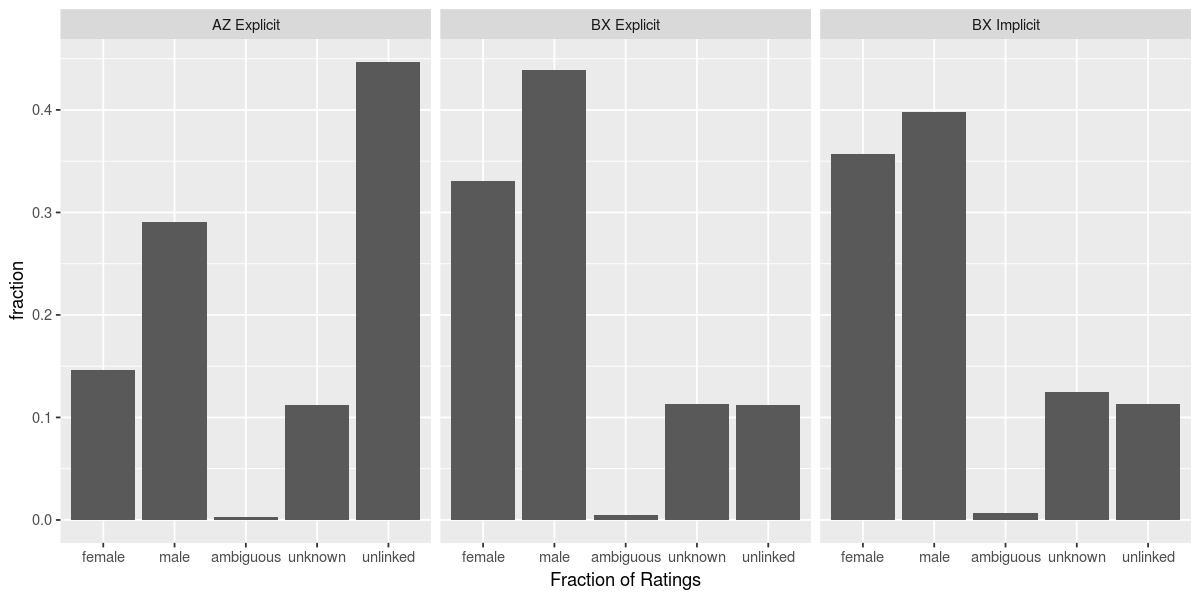

In [20]:
rating_coverage = user_books %>%
    select(Set, bookID, gender) %>%
    group_by(Set, gender) %>%
    summarize(count=n()) %>%
    group_by(Set) %>%
    mutate(fraction=count / sum(count))
ggplot(rating_coverage) +
    aes(x=gender, y=fraction) +
    geom_bar(stat='identity') +
    facet_grid(~ Set) +
    xlab('Fraction of Ratings')

In [21]:
rating_coverage %>%
    select(Set, gender, fraction) %>%
    spread(Set, fraction)

gender,AZ Explicit,BX Explicit,BX Implicit
female,0.146749284,0.330794255,0.357369861
male,0.290945323,0.439300167,0.398181672
ambiguous,0.003238261,0.004840117,0.006517017
unknown,0.112280483,0.113068317,0.125271542
unlinked,0.446786648,0.111997144,0.112659908


In [22]:
rating_coverage %>%
    select(Set, gender, fraction) %>%
    spread(gender, fraction) %>%
    transmute(known=female + male, unknown=unknown+unlinked, ambiguous=ambiguous)

Adding missing grouping variables: `Set`


Set,known,unknown,ambiguous
AZ Explicit,0.4376946,0.5590671,0.003238261
BX Explicit,0.7700944,0.2250655,0.004840117
BX Implicit,0.7555515,0.2379315,0.006517017


We have 75% coverage over ratings (47% for Amazon)

### How are profiles sizes distributed?

First, we want to see the distribution of _profile sizes_:

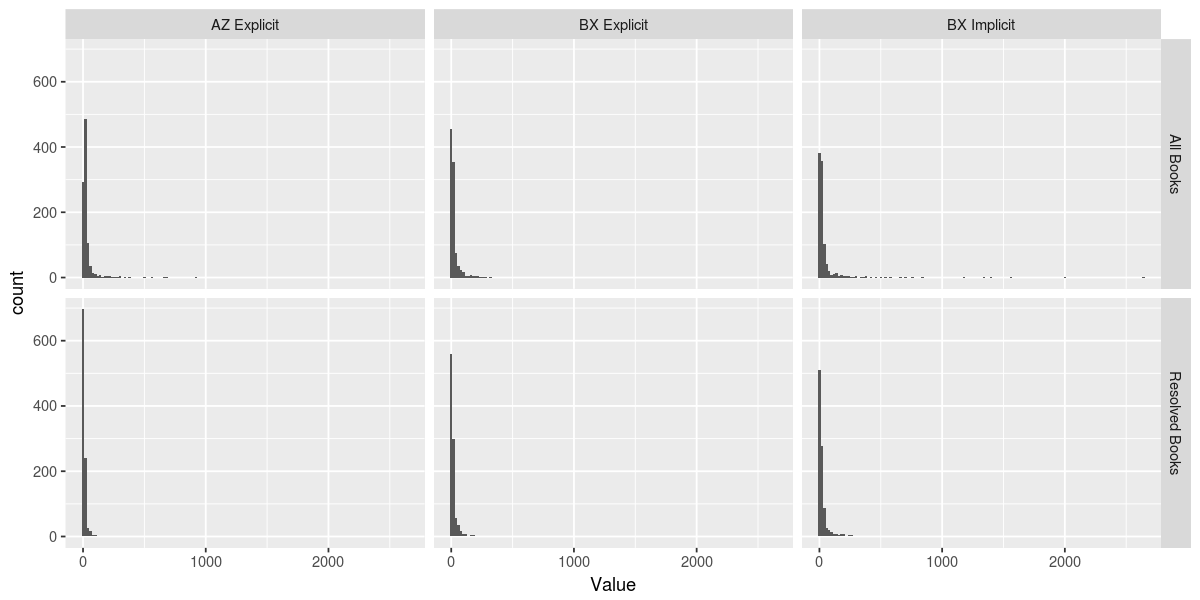

In [23]:
profile_stats = profile_info %>%
    select(Set, userID, count, known) %>%
    gather("Scope", "Value", count, known) %>%
    mutate(Scope = recode_factor(Scope,
                                 count="All Books",
                                 known="Resolved Books",
                                 .ordered=TRUE))
ggplot(profile_stats) +
    aes(x=Value) +
    geom_histogram(binwidth=20) +
    facet_grid(Scope ~ Set)

Lots of concentration low, and some outliers. We will filter out large profiles.

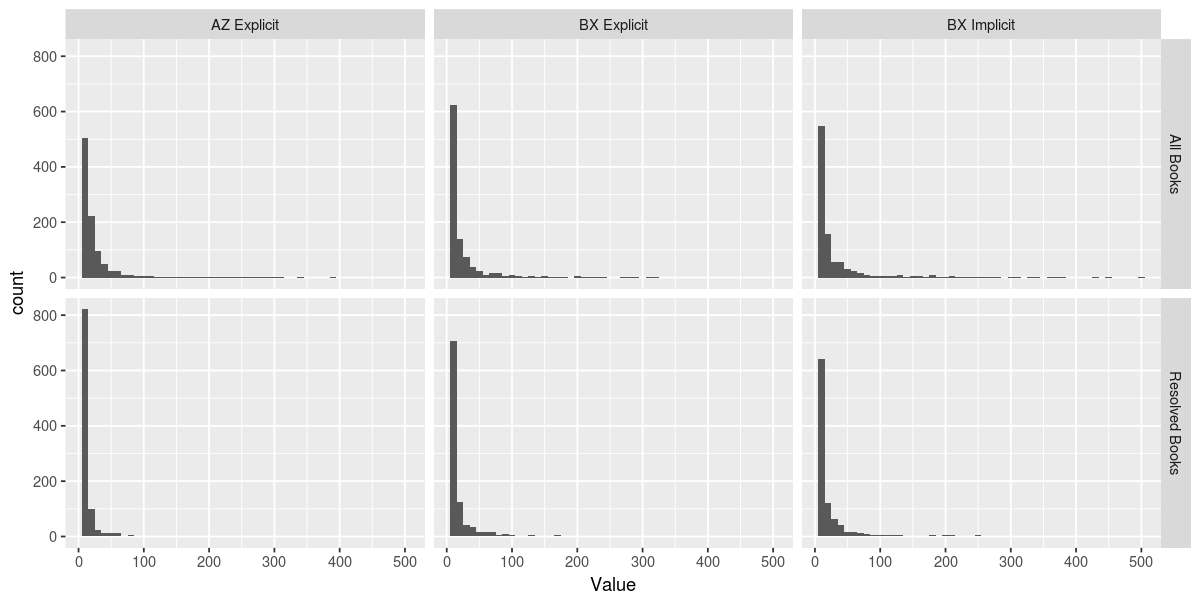

In [24]:
ggplot(filter(profile_stats, Value <= 500)) +
    aes(x=Value) +
    geom_histogram(binwidth=10) +
    facet_grid(Scope ~ Set)

In [25]:
profile_info %>%
    transmute(userID, Set, keep = known <= 250) %>%
    spread(Set, keep) %>%
    summary()

     userID        AZ Explicit     BX Explicit     BX Implicit    
 Min.   :    242   Mode :logical   Mode :logical   Mode :logical  
 1st Qu.: 106150   FALSE:4         FALSE:1         FALSE:24       
 Median : 205383   TRUE :996       TRUE :999       TRUE :976      
 Mean   :1423375   NA's :1945      NA's :1945      NA's :1945     
 3rd Qu.:1992182                                                  
 Max.   :8024986                                                  

Let's look at fraction known:

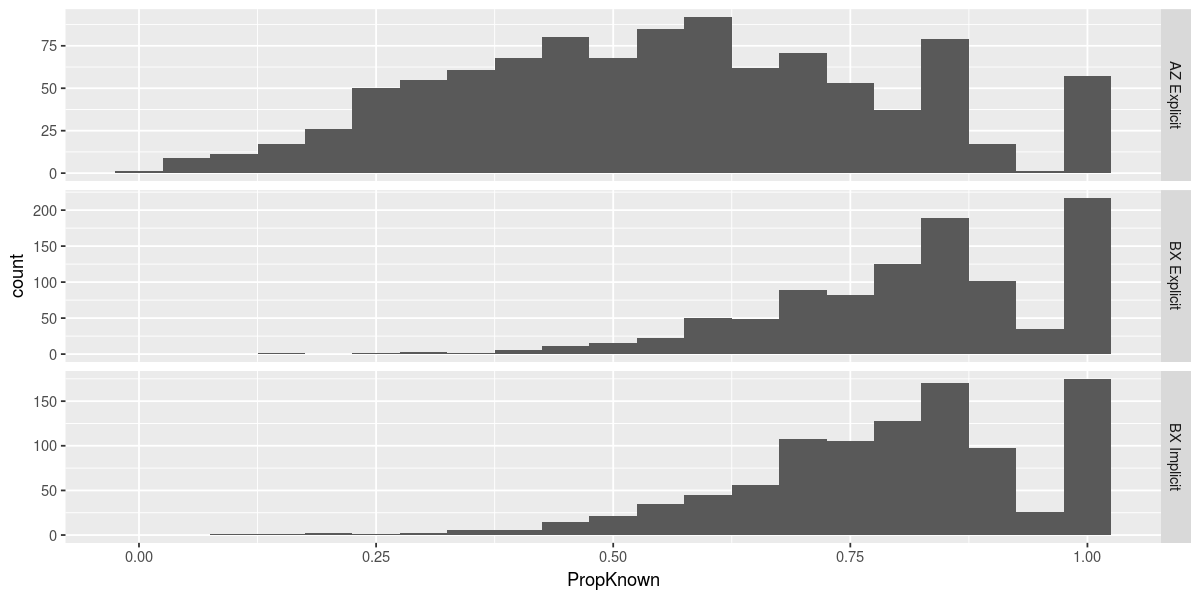

In [26]:
ggplot(profile_info) +
    aes(x=PropKnown) +
    geom_histogram(binwidth=0.05) +
    facet_grid(Set ~ ., scales="free_y")

## How are profile gender biases distributed?

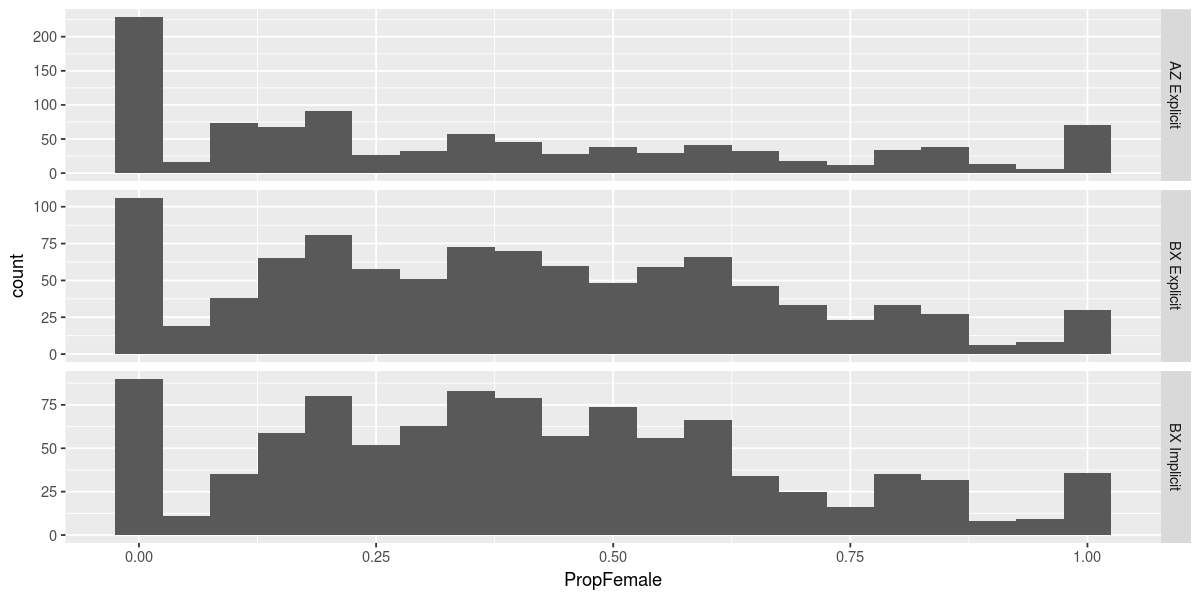

In [27]:
ggplot(profile_info) +
    aes(x=PropFemale) +
    geom_histogram(binwidth=0.05) +
    facet_grid(Set ~ ., scales="free_y")

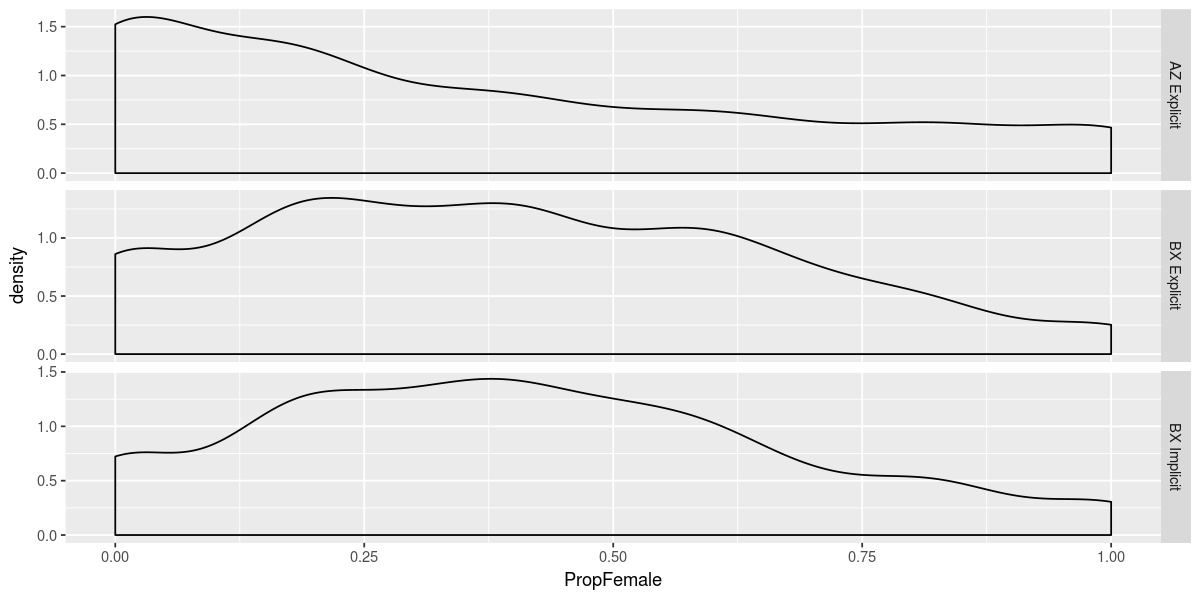

In [28]:
ggplot(profile_info) +
    aes(x=PropFemale) +
    geom_density() +
    facet_grid(Set ~ ., scales="free_y")

## Modeling Profile Sizes

Question: How should we model profile sizes, since they are limited to at least 5?  There are three solid options:

- $n \sim \mathrm{NegBinomial}(\nu, \gamma), n \ge 5$ - truncated negative binomial with rejection sampling
- $n - 5 \sim \mathrm{NegBinomial}(\nu, \gamma)$ - transformed negative binomial
- $n - 5 \sim \mathrm{Poisson}(\lambda)$ - transformed poisson

We're going to test them.

In [31]:
bxi_data = profile_info %>% filter(Set == 'BX Implicit')

### Truncated Negative Binomial

In [53]:
trunc_nb = '
data {
    int<lower=0> J;
    int<lower=5> n[J];
}
parameters {
    real<lower=0> nu;
    real<lower=0> gamma;
}
model {
    n ~ neg_binomial_2(nu, gamma);
}
generated quantities {
    vector[J] log_lik;
    int nP = 0;
    while (nP < 5) {
        nP = neg_binomial_2_rng(nu, gamma);
    }
    for (i in 1:J) {
        log_lik[i] = neg_binomial_2_lpmf(n[i] | nu, gamma);
    }
}
'

In [79]:
bxi_trunc_nb_fits =
    stan(model_code=trunc_nb, model_name='trunc_nb',
         data=list(J=nrow(bxi_data), n=bxi_data$known),
         iter=4000)

In [80]:
print(bxi_trunc_nb_fits, pars=c("nu", "gamma", "nP"))

Inference for Stan model: trunc_nb.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
nu    37.70    0.02  1.52 34.86 36.65 37.66 38.73  40.79  6131    1
gamma  0.64    0.00  0.02  0.60  0.63  0.64  0.66   0.69  6672    1
nP    46.70    0.55 47.73  5.00 14.00 31.00 62.00 176.02  7591    1

Samples were drawn using NUTS(diag_e) at Fri Jan 19 15:18:52 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Shifted Negative Binomial

In [56]:
shift_nb = '
data {
    int<lower=0> J;
    int<lower=5> n[J];
}
parameters {
    real<lower=0> nu;
    real<lower=0> gamma;
}
model {
    for (i in 1:J) {
        n[i] - 5 ~ neg_binomial_2(nu, gamma);
    }
}
generated quantities {
    vector[J] log_lik;
    int nP;
    nP = neg_binomial_2_rng(nu, gamma) + 5;
    for (i in 1:J) {
        log_lik[i] = neg_binomial_2_lpmf(n[i] - 5 | nu, gamma);
    }
}
'

In [57]:
bxi_shift_nb_fits =
    stan(model_code=shift_nb, model_name='shift_nb',
         data=list(J=nrow(bxi_data), n=bxi_data$known),
         iter=4000)

In [62]:
print(bxi_shift_nb_fits, pars=c("nu", "gamma", "nP"))

Inference for Stan model: shift_nb.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
nu    32.80    0.02  1.86 29.37 31.50 32.73 34.05  36.59  8000    1
gamma  0.32    0.00  0.01  0.29  0.31  0.32  0.33   0.34  7104    1
nP    38.34    0.68 60.87  5.00  6.00 14.00 43.00 218.02  7917    1

Samples were drawn using NUTS(diag_e) at Fri Jan 19 15:12:40 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Shifted Poisson

In [63]:
shift_p = '
data {
    int<lower=0> J;
    int<lower=5> n[J];
}
parameters {
    real<lower=0> lambda;
}
model {
    for (i in 1:J) {
        n[i] - 5 ~ poisson(lambda);
    }
}
generated quantities {
    vector[J] log_lik;
    int nP;
    nP = poisson_rng(lambda) + 5;
    for (i in 1:J) {
        log_lik[i] = poisson_lpmf(n[i] - 5 | lambda);
    }
}
'

In [81]:
bxi_shift_p_fits =
    stan(model_code=shift_p, model_name='shift_p',
         data=list(J=nrow(bxi_data), n=bxi_data$known),
         iter=4000)

In [82]:
print(bxi_shift_p_fits, pars=c("lambda", "nP"))

Inference for Stan model: shift_p.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
lambda 32.56    0.00 0.18 32.21 32.44 32.56 32.68 32.92  2888    1
nP     37.65    0.06 5.66 27.00 34.00 37.00 41.00 49.00  8000    1

Samples were drawn using NUTS(diag_e) at Fri Jan 19 15:19:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Show Distributions

In [83]:
bxi_sizes =
    bind_rows(Observed = select(bxi_data, Size=known),
              NBTrunc = data_frame(Size=rstan::extract(bxi_trunc_nb_fits, permuted=TRUE)$nP),
              NBShift = data_frame(Size=rstan::extract(bxi_shift_nb_fits, permuted=TRUE)$nP),
              PShift = data_frame(Size=rstan::extract(bxi_shift_p_fits, permuted=TRUE)$nP),
              .id="Set")

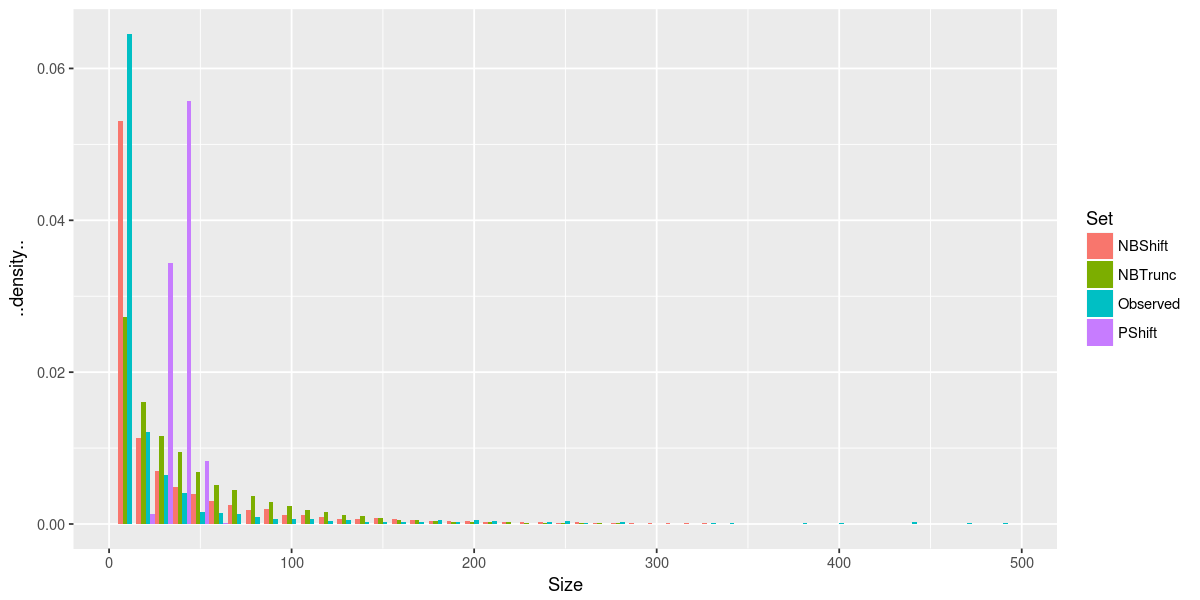

In [84]:
ggplot(bxi_sizes %>% filter(Size <= 500)) +
    aes(x=Size, fill=Set, y=..density..) +
    geom_histogram(bins=50, position='dodge')

### Fit Comparison

In [85]:
nbt_ll = extract_log_lik(bxi_trunc_nb_fits)
nbs_ll = extract_log_lik(bxi_shift_nb_fits)
ps_ll = extract_log_lik(bxi_shift_p_fits)

In [86]:
nbt_loo = loo(nbt_ll)
print(nbt_loo)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.”

Computed from 8000 by 1000 log-likelihood matrix

         Estimate    SE
elpd_loo  -4572.1  73.0
p_loo        10.0   3.7
looic      9144.2 145.9

Pareto k diagnostic values:
                         Count  Pct 
(-Inf, 0.5]   (good)     999   99.9%
 (0.5, 0.7]   (ok)         0    0.0%
   (0.7, 1]   (bad)        1    0.1%
   (1, Inf)   (very bad)   0    0.0%
See help('pareto-k-diagnostic') for details.

In [87]:
nbs_loo = loo(nbs_ll)
print(nbs_loo)

Computed from 8000 by 1000 log-likelihood matrix

         Estimate    SE
elpd_loo  -3976.9  67.8
p_loo         5.9   2.0
looic      7953.8 135.6

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

In [88]:
ps_loo = loo(ps_ll)
print(ps_loo)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.”

Computed from 8000 by 1000 log-likelihood matrix

         Estimate      SE
elpd_loo -56277.1  9467.7
p_loo       354.8   105.8
looic    112554.1 18935.4

Pareto k diagnostic values:
                         Count  Pct 
(-Inf, 0.5]   (good)     983   98.3%
 (0.5, 0.7]   (ok)         2    0.2%
   (0.7, 1]   (bad)        5    0.5%
   (1, Inf)   (very bad)  10    1.0%
See help('pareto-k-diagnostic') for details.

In [89]:
compare(nbt_loo, nbs_loo, ps_loo)

,looic,se_looic,elpd_loo,se_elpd_loo,p_loo,se_p_loo
nbs_loo,7953.794,135.5629,-3976.897,67.78144,5.887624,1.952712
nbt_loo,9144.164,145.9267,-4572.082,72.96336,10.030803,3.749094
ps_loo,112554.111,18935.4379,-56277.056,9467.71897,354.797094,105.804028


## Bayesian Modeling

In [31]:
sets = levels(profile_info$Set)

### Beta

First fit the profile Beta model:

In [32]:
beta_model = stan_model(file="models/profile-beta.stan")
beta_model

S4 class stanmodel 'profile-beta' coded as follows:
data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0,upper=1> phi;
    real<lower=0.1> lambda;
    real<lower=0> nRate;
    real<lower=0,upper=1> theta[J];
}
transformed parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    alpha = lambda * phi;
    beta = lambda * (1 - phi);
}
model {
    phi ~ beta(1,1);
    lambda ~ pareto(0.1, 1.5);

    theta ~ beta(alpha, beta);
    n ~ poisson(nRate);
    y ~ binomial(n, theta);
}
generated quantities {
    real thetaP;
    int<lower=0> nP;
    int<lower=0> yP;
    
    thetaP = beta_rng(alpha, beta);
    nP = poisson_rng(nRate);
    yP = binomial_rng(nP, thetaP);
} 

In [33]:
beta_fits = map(sets, function(set) {
    message("fitting ", set)
    df = profile_info %>% filter(Set == set)
    sampling(beta_model,
             data=list(J=nrow(df),
                       n=df$known,
                       y=df$NFemale),
             chains=8)
})

fitting AZ Explicit
Warning message:
“There were 101 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”fitting BX Explicit
fitting BX Implicit


In [34]:
names(beta_fits) = sets

In [35]:
print(beta_fits[['AZ Explicit']], pars=c("phi", "lambda", "nRate", "thetaP", "nP", "yP"))

Inference for Stan model: profile-beta.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
phi     0.40    0.00  0.01  0.38  0.39  0.40  0.41  0.42  8000    1
lambda  1.94    0.00  0.08  1.78  1.88  1.94  2.00  2.11  5292    1
nRate  67.07    0.00  0.26 66.55 66.89 67.07 67.25 67.58  8000    1
thetaP  0.40    0.00  0.28  0.01  0.15  0.36  0.63  0.95  8000    1
nP     66.96    0.10  8.13 51.00 61.00 67.00 72.00 83.00  7309    1
yP     26.86    0.22 19.77  0.00 10.00 24.00 42.00 67.00  8000    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 13:46:16 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [36]:
print(beta_fits[['BX Explicit']], pars=c("phi", "lambda", "nRate", "thetaP", "nP", "yP"))

Inference for Stan model: profile-beta.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
phi     0.42    0.00 0.01  0.41  0.42  0.42  0.43  0.44  8000    1
lambda  3.94    0.00 0.25  3.49  3.77  3.94  4.11  4.46  2593    1
nRate  20.93    0.00 0.14 20.65 20.83 20.93 21.02 21.21  8000    1
thetaP  0.43    0.00 0.22  0.06  0.25  0.41  0.59  0.87  8000    1
nP     20.95    0.05 4.54 13.00 18.00 21.00 24.00 30.00  7382    1
yP      9.00    0.06 5.55  0.00  5.00  8.00 13.00 21.00  8000    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 13:47:16 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [37]:
print(beta_fits[['BX Implicit']], pars=c("phi", "lambda", "nRate", "thetaP", "nP", "yP"))

Inference for Stan model: profile-beta.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
phi     0.41    0.00  0.01  0.39  0.40  0.41  0.41  0.42  8000    1
lambda  4.26    0.00  0.26  3.78  4.09  4.25  4.43  4.79  3481    1
nRate  43.99    0.00  0.21 43.58 43.85 43.99 44.13 44.41  8000    1
thetaP  0.41    0.00  0.22  0.06  0.24  0.40  0.57  0.84  7816    1
nP     43.92    0.07  6.56 32.00 39.00 44.00 48.00 57.00  8000    1
yP     18.14    0.12 10.30  2.00 10.00 17.00 25.00 40.00  7816    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 13:48:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [38]:
beta_sims = map_dfr(beta_fits, function(fit) {
    sim = rstan::extract(fit, permuted=TRUE)
    data_frame(Sim=1:nrow(sim$thetaP),
               Alpha=sim$alpha, Beta=sim$alpha, NRate=sim$nRate,
               Theta=sim$thetaP, N=sim$nP, Y=sim$yP) %>%
        mutate(Prop=Y/N)
}, .id="Set")
beta_sims

Set,Sim,Alpha,Beta,NRate,Theta,N,Y,Prop
AZ Explicit,1,0.7467329,0.7467329,67.05755,0.89525934,67,60,0.89552239
AZ Explicit,2,0.7719095,0.7719095,66.79222,0.83792507,64,50,0.78125000
AZ Explicit,3,0.7464775,0.7464775,67.35411,0.88270513,68,62,0.91176471
AZ Explicit,4,0.8394684,0.8394684,67.26690,0.43203643,66,33,0.50000000
AZ Explicit,5,0.8134264,0.8134264,66.76819,0.33779680,62,23,0.37096774
AZ Explicit,6,0.7908993,0.7908993,66.74397,0.30160809,75,15,0.20000000
AZ Explicit,7,0.7828300,0.7828300,67.10184,0.56790428,68,50,0.73529412
AZ Explicit,8,0.8039837,0.8039837,66.84533,0.02571241,83,1,0.01204819
AZ Explicit,9,0.7891016,0.7891016,67.47493,0.38912673,63,19,0.30158730
AZ Explicit,10,0.7984091,0.7984091,67.06388,0.03190329,74,5,0.06756757


In [39]:
beta_res = beta_sims %>% select(Set, InferredBias=Theta, PredProp=Prop) %>%
    gather("Method", "Value", InferredBias, PredProp) %>%
    bind_rows(profile_info %>% select(Set, Value=PropFemale) %>% mutate(Method="ObsProp"))

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [40]:
beta_means = beta_res %>%
    group_by(Set, Method) %>%
    summarize(Mean=mean(Value, na.rm = TRUE),
              Var=var(Value, na.rm=TRUE))
beta_means

Set,Method,Mean,Var
AZ Explicit,InferredBias,0.4006759,0.08093843
AZ Explicit,ObsProp,0.3797911,0.08958080
AZ Explicit,PredProp,0.4007807,0.08334846
BX Explicit,InferredBias,0.4271781,0.05012438
BX Explicit,ObsProp,0.4200225,0.06743889
BX Explicit,PredProp,0.4299865,0.06018079
BX Implicit,InferredBias,0.4135246,0.04636838
BX Implicit,ObsProp,0.4057969,0.06428204
BX Implicit,PredProp,0.4134602,0.05080703


In [41]:
beta_res_dens = beta_res %>%
    group_by(Set, Method) %>%
    summarize(Dens=list(density_frame(Value, from=0, to=1))) %>%
    unnest(Dens)
beta_res_dens

Set,Method,value,density
AZ Explicit,InferredBias,0.000000000,1.046692
AZ Explicit,InferredBias,0.001956947,1.077877
AZ Explicit,InferredBias,0.003913894,1.108523
AZ Explicit,InferredBias,0.005870841,1.138573
AZ Explicit,InferredBias,0.007827789,1.167618
AZ Explicit,InferredBias,0.009784736,1.195910
AZ Explicit,InferredBias,0.011741683,1.223415
AZ Explicit,InferredBias,0.013698630,1.250057
AZ Explicit,InferredBias,0.015655577,1.275390
AZ Explicit,InferredBias,0.017612524,1.299779


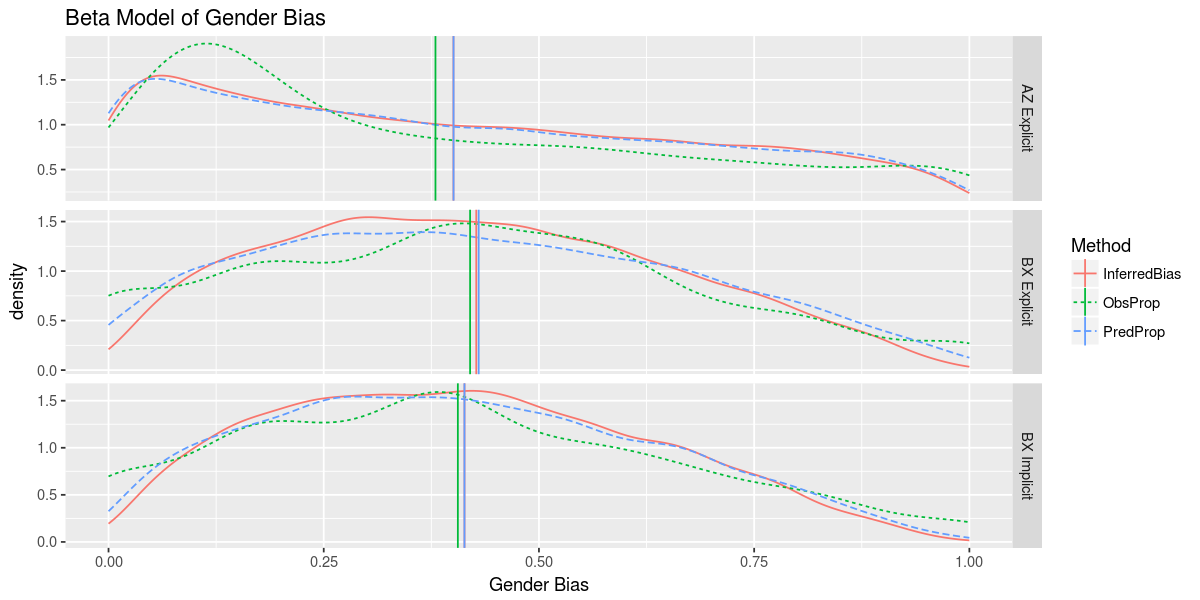

In [42]:
ggplot(beta_res_dens) +
    aes(x=value, y=density, color=Method, linetype=Method) +
    geom_line() +
    geom_vline(data=beta_means, mapping=aes(xintercept=Mean, color=Method)) +
    facet_grid(Set ~ ., scales = 'free') +
    xlab("Gender Bias") +
    ggtitle("Beta Model of Gender Bias")

### Beta with Negative Binomial

This is a beta-based model, but with a negative binomail distribution for the profile size.

In [43]:
beta_nb_model = stan_model(file='models/profile-beta-nb.stan')
beta_nb_model

S4 class stanmodel 'profile-beta-nb' coded as follows:
data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0,upper=1> phi;
    real<lower=0> lambda;

    real<lower=0> nMu;
    real<lower=0> nDisp;

    real<lower=0,upper=1> theta[J];
}
transformed parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    alpha = lambda * phi;
    beta = lambda * (1 - phi);
}
model {
    phi ~ beta(1,1);
    lambda ~ lognormal(0, 5);

    nMu ~ lognormal(0, 5);
    nDisp ~ lognormal(0, 5);

    theta ~ beta(alpha, beta);
    n ~ neg_binomial_2(nMu, nDisp);
    y ~ binomial(n, theta);
}
generated quantities {
    real thetaP;
    int<lower=0> nP;
    int<lower=0> yP;
    
    thetaP = beta_rng(alpha, beta);
    nP = neg_binomial_2_rng(nMu, nDisp);
    yP = binomial_rng(nP, thetaP);
} 

In [44]:
beta_nb_fits = map(sets, function(set) {
    message("fitting ", set)
    df = profile_info %>% filter(Set == set)
    sampling(beta_nb_model,
             data=list(J=nrow(df),
                       n=df$known,
                       y=df$NFemale),
             chains=8)
})

fitting AZ Explicit
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”fitting BX Explicit
fitting BX Implicit


In [45]:
names(beta_nb_fits) = sets

In [46]:
print(beta_nb_fits[['AZ Explicit']], pars=c("phi", "lambda", "nMu", "nDisp", "thetaP", "nP", "yP"))

Inference for Stan model: profile-beta-nb.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
phi     0.40    0.00  0.01  0.38  0.39  0.40  0.41   0.42  5911    1
lambda  1.95    0.00  0.09  1.79  1.89  1.95  2.01   2.12  5653    1
nMu    67.12    0.02  2.20 63.51 65.79 67.12 68.42  70.97  7892    1
nDisp   1.27    0.00  0.06  1.17  1.23  1.27  1.30   1.37  8000    1
thetaP  0.40    0.00  0.29  0.01  0.14  0.36  0.63   0.95  7447    1
nP     66.28    0.66 59.46  2.00 23.00 49.00 92.00 225.02  8000    1
yP     26.64    0.40 35.68  0.00  4.00 14.00 35.00 125.00  8000    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 13:53:45 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [47]:
print(beta_nb_fits[['BX Explicit']], pars=c("phi", "lambda", "nMu", "nDisp", "thetaP", "nP", "yP"))

Inference for Stan model: profile-beta-nb.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
phi     0.42    0.00  0.01  0.41  0.42  0.42  0.43  0.44  8000    1
lambda  3.96    0.00  0.24  3.52  3.80  3.95  4.12  4.45  2995    1
nMu    20.95    0.01  0.64 19.74 20.52 20.93 21.36 22.23  8000    1
nDisp   1.10    0.00  0.05  1.01  1.07  1.10  1.13  1.19  8000    1
thetaP  0.42    0.00  0.22  0.06  0.25  0.41  0.59  0.86  7901    1
nP     20.94    0.23 20.50  0.00  6.00 15.00 29.00 76.00  7967    1
yP      8.86    0.12 11.09  0.00  2.00  5.00 12.00 40.00  8000    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 13:55:02 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [48]:
print(beta_nb_fits[['BX Implicit']], pars=c("phi", "lambda", "nMu", "nDisp", "thetaP", "nP", "yP"))

Inference for Stan model: profile-beta-nb.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
phi     0.41    0.00  0.01  0.39  0.40  0.41  0.41   0.42  8000    1
lambda  4.28    0.00  0.26  3.79  4.10  4.27  4.45   4.81  3068    1
nMu    44.09    0.02  1.86 40.62 42.78 44.06 45.35  47.87  8000    1
nDisp   0.59    0.00  0.02  0.55  0.57  0.59  0.60   0.63  8000    1
thetaP  0.41    0.00  0.22  0.05  0.24  0.39  0.57   0.84  7816    1
nP     43.97    0.64 57.08  0.00  6.00 23.00 59.00 207.02  8000    1
yP     17.86    0.30 26.97  0.00  2.00  8.00 22.00  94.02  8000    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 13:56:21 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [49]:
beta_nb_sims = map_dfr(beta_nb_fits, function(fit) {
    sim = rstan::extract(fit, permuted=TRUE)
    data_frame(Sim=1:nrow(sim$thetaP),
               Alpha=sim$alpha, Beta=sim$beta, 
               NMu=sim$nMu, NDisp=sim$nDisp,
               Theta=sim$thetaP, N=sim$nP, Y=sim$yP) %>%
        mutate(Prop=ifelse(N > 0, Y/N, NA))
}, .id="Set")
beta_nb_sims

Set,Sim,Alpha,Beta,NMu,NDisp,Theta,N,Y,Prop
AZ Explicit,1,0.7756603,1.214238,66.47402,1.301352,0.08452055,12,2,0.16666667
AZ Explicit,2,0.7603118,1.163808,67.96164,1.300799,0.11355949,54,5,0.09259259
AZ Explicit,3,0.7395489,1.088271,65.49450,1.324430,0.03189236,159,11,0.06918239
AZ Explicit,4,0.7717179,1.219237,62.67958,1.248477,0.17388901,78,11,0.14102564
AZ Explicit,5,0.7762847,1.137162,64.77755,1.307088,0.66057249,92,59,0.64130435
AZ Explicit,6,0.7467988,1.110366,64.08815,1.234312,0.23777813,120,29,0.24166667
AZ Explicit,7,0.7600425,1.128585,67.13905,1.288503,0.80685956,11,10,0.90909091
AZ Explicit,8,0.8193364,1.295238,67.19057,1.237755,0.85189759,26,25,0.96153846
AZ Explicit,9,0.7656480,1.121780,65.78798,1.301292,0.02404644,33,0,0.00000000
AZ Explicit,10,0.8277103,1.200782,64.49155,1.136372,0.21287819,9,4,0.44444444


In [50]:
beta_nb_res = beta_nb_sims %>% select(Set, InferredBias=Theta, PredProp=Prop) %>%
    gather("Method", "Value", InferredBias, PredProp) %>%
    filter(!is.na(Value)) %>%
    bind_rows(profile_info %>% select(Set, Value=PropFemale) %>% mutate(Method="ObsProp"))

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [51]:
beta_nb_means = beta_nb_res %>%
    group_by(Set, Method) %>%
    summarize(Mean=mean(Value, na.rm = TRUE),
              Var=var(Value, na.rm=TRUE))
beta_nb_means

Set,Method,Mean,Var
AZ Explicit,InferredBias,0.3993310,0.08185859
AZ Explicit,ObsProp,0.3797911,0.08958080
AZ Explicit,PredProp,0.4001211,0.09051142
BX Explicit,InferredBias,0.4228337,0.04848924
BX Explicit,ObsProp,0.4200225,0.06743889
BX Explicit,PredProp,0.4230443,0.07627534
BX Implicit,InferredBias,0.4070089,0.04627643
BX Implicit,ObsProp,0.4057969,0.06428204
BX Implicit,PredProp,0.4034934,0.06987799


In [52]:
beta_nb_res_dens = beta_nb_res %>%
    group_by(Set, Method) %>%
    summarize(Dens=list(density_frame(Value, from=0, to=1))) %>%
    unnest(Dens)
beta_nb_res_dens

Set,Method,value,density
AZ Explicit,InferredBias,0.000000000,1.058330
AZ Explicit,InferredBias,0.001956947,1.090105
AZ Explicit,InferredBias,0.003913894,1.121328
AZ Explicit,InferredBias,0.005870841,1.151977
AZ Explicit,InferredBias,0.007827789,1.182010
AZ Explicit,InferredBias,0.009784736,1.210994
AZ Explicit,InferredBias,0.011741683,1.239192
AZ Explicit,InferredBias,0.013698630,1.266581
AZ Explicit,InferredBias,0.015655577,1.293109
AZ Explicit,InferredBias,0.017612524,1.318284


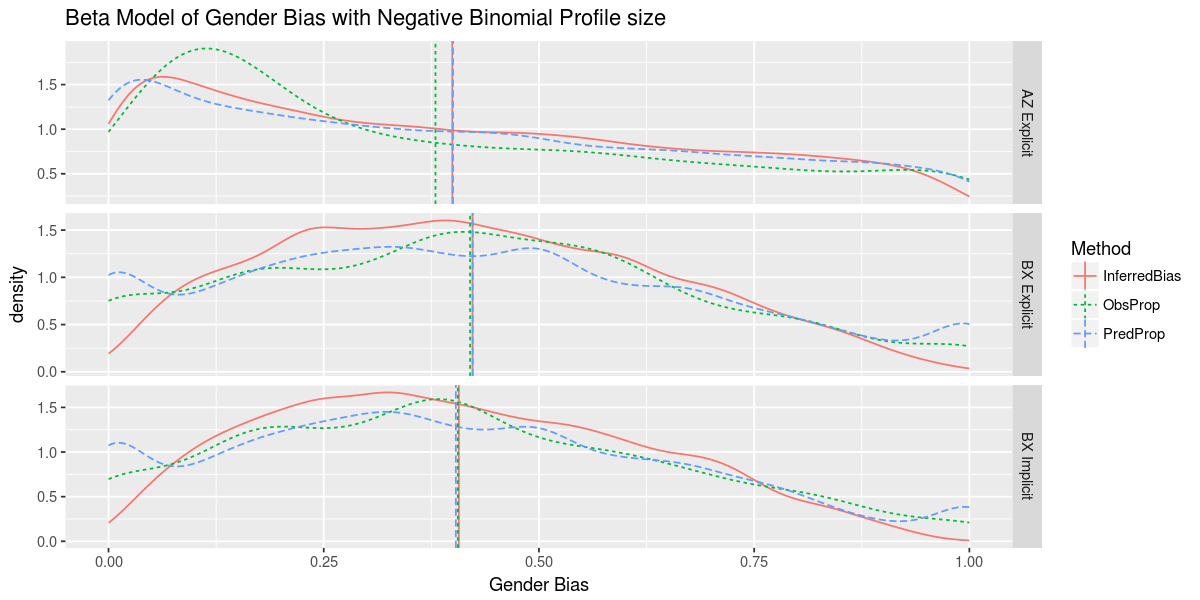

In [53]:
ggplot(beta_nb_res_dens) +
    aes(x=value, y=density, color=Method, linetype=Method) +
    geom_line() +
    geom_vline(data=beta_nb_means, mapping=aes(xintercept=Mean, color=Method, linetype=Method)) +
    facet_grid(Set ~ ., scales = 'free') +
    xlab("Gender Bias") +
    ggtitle("Beta Model of Gender Bias with Negative Binomial Profile size")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


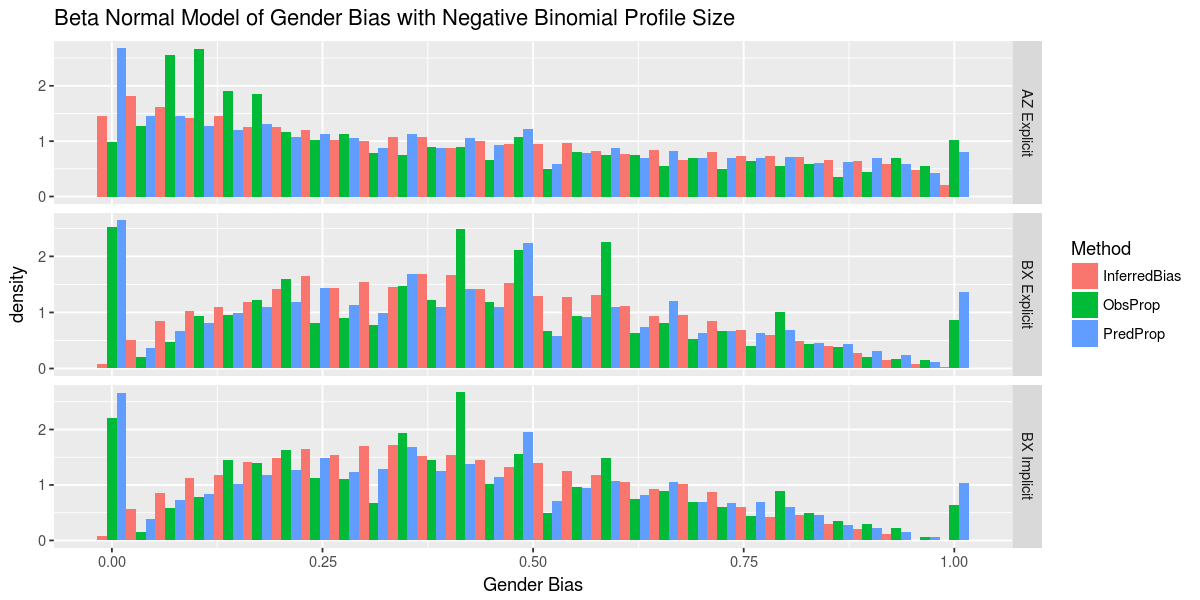

In [54]:
ggplot(beta_nb_res) +
    aes(x=Value, fill=Method) +
    geom_histogram(position='dodge', mapping=aes(y=..density..)) +
    facet_grid(Set ~ ., scales = 'free') +
    xlab("Gender Bias") +
    ggtitle("Beta Normal Model of Gender Bias with Negative Binomial Profile Size")

### Logit Normal Model

Now fit the logit-normal model. This model is defined by

$$\begin{align}
\mathrm{logit}(\theta) & \sim \mathrm{Normal}(\mu, \sigma^2) \\
n & \sim \mathrm{NegBinomial}(\alpha, \beta) \\
y & \sim \mathrm{Binomial}(n, \theta)
\end{align}$$

with priors

$$\begin{align}
\mu & \sim \mathrm{Normal}(0, 10) \\
\sigma^2 & \sim \mathrm{Normal}(0, 10) \\
\alpha & \sim \mathrm{HalfNormal}(0, 10) \\
\beta & \sim \mathrm{HalfNormal}(0, 10)
\end{align}$$

In [55]:
ln_model = stan_model(file='models/profile-logit-normal.stan')
ln_model

hash mismatch so recompiling; make sure Stan code ends with a blank line


S4 class stanmodel 'profile-logit-normal' coded as follows:
data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real mu;
    real<lower=0.01> sigma;
    
    real<lower=0> nMu;
    real<lower=0> nDisp;

    real nTheta[J];
}
transformed parameters {
    real<lower=0,upper=1> theta[J];
    theta = inv_logit(nTheta);
}
model {
    nMu ~ lognormal(0, 5);
    nDisp ~ lognormal(0, 5);
 
    mu ~ normal(0, 100);
    sigma ~ lognormal(0, 5);
 
    n ~ neg_binomial_2(nMu, nDisp);
    nTheta ~ normal(mu, sigma);
    y ~ binomial(n, theta);
}
generated quantities {
    real<lower=0, upper=1> thetaP;
    int<lower=0> nP;
    int<lower=0> yP;
    
    thetaP = inv_logit(normal_rng(mu, sigma));
    nP = neg_binomial_2_rng(nMu, nDisp);
    yP = binomial_rng(nP, thetaP);
} 

In [56]:
ln_fits = map(sets, function(set) {
    message("fitting ", set)
    df = profile_info %>% filter(Set == set)
    sampling(ln_model,
             data=list(J=nrow(df),
                       n=df$known,
                       y=df$NFemale),
             chains=8)
})

fitting AZ Explicit
fitting BX Explicit
fitting BX Implicit
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [57]:
names(ln_fits) = sets

In [58]:
print(ln_fits[['AZ Explicit']], pars=c("mu", "sigma", "nMu", 'nDisp', "thetaP", "nP", "yP"))

Inference for Stan model: profile-logit-normal.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
mu     -0.68    0.00  0.06 -0.80 -0.72 -0.68 -0.64  -0.57  8000    1
sigma   1.79    0.00  0.05  1.70  1.75  1.78  1.82   1.88  8000    1
nMu    67.12    0.02  1.92 63.48 65.80 67.09 68.38  70.95  8000    1
nDisp   1.27    0.00  0.05  1.17  1.23  1.27  1.30   1.37  8000    1
thetaP  0.39    0.00  0.29  0.01  0.13  0.33  0.62   0.95  8000    1
nP     67.11    0.66 58.76  3.00 24.00 51.00 94.00 220.00  8000    1
yP     25.91    0.38 34.06  0.00  4.00 13.00 35.00 125.00  8000    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 14:10:28 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [59]:
print(ln_fits[['BX Explicit']], pars=c("mu", "sigma", "nMu", 'nDisp', "thetaP", "nP", "yP"))

Inference for Stan model: profile-logit-normal.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu     -0.39    0.00  0.04 -0.47 -0.42 -0.39 -0.36 -0.30  8000    1
sigma   1.13    0.00  0.04  1.05  1.10  1.13  1.16  1.21  2266    1
nMu    20.95    0.01  0.66 19.72 20.49 20.93 21.38 22.28  8000    1
nDisp   1.10    0.00  0.05  1.01  1.07  1.10  1.13  1.19  8000    1
thetaP  0.42    0.00  0.22  0.07  0.24  0.40  0.60  0.86  7780    1
nP     21.08    0.23 20.58  0.00  6.00 15.00 30.00 77.00  7917    1
yP      8.82    0.13 10.76  0.00  2.00  5.00 12.00 39.00  7313    1

Samples were drawn using NUTS(diag_e) at Thu Jan 18 14:11:26 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [60]:
print(ln_fits[['BX Implicit']], pars=c("mu", "sigma", "nMu", "nDisp", "thetaP", "nP", "yP"))

Inference for Stan model: profile-logit-normal.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
mu     -0.46    0.00  0.04 -0.54 -0.49 -0.46 -0.43  -0.38  3177 1.00
sigma   1.09    0.00  0.06  1.02  1.06  1.09  1.12   1.17  1146 1.00
nMu    44.02    0.06  2.44 40.65 42.81 44.04 45.33  47.75  1489 1.00
nDisp   0.59    0.00  0.03  0.55  0.57  0.59  0.60   0.63  1405 1.01
thetaP  0.41    0.00  0.22  0.07  0.23  0.39  0.57   0.84  8000 1.00
nP     44.20    0.66 58.65  0.00  6.00 23.00 60.00 207.02  8000 1.00
yP     18.21    0.34 29.31  0.00  2.00  7.00 23.00 100.00  7477 1.00

Samples were drawn using NUTS(diag_e) at Thu Jan 18 14:12:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [61]:
ln_sims = map_dfr(ln_fits, function(fit) {
    sim = rstan::extract(fit, permuted=TRUE)
    data_frame(Sim=1:nrow(sim$thetaP),
               Mu=sim$mu, Sigma=sim$sigma,
               NMu=sim$nMu, NDisp=sim$nDisp,
               Theta=sim$thetaP, N=sim$nP, Y=sim$yP) %>%
        mutate(Prop=ifelse(N > 0, Y/N, NA))
}, .id="Set")
ln_sims

Set,Sim,Mu,Sigma,NMu,NDisp,Theta,N,Y,Prop
AZ Explicit,1,-0.7173754,1.711028,66.11994,1.198452,0.24132036,32,11,0.34375000
AZ Explicit,2,-0.6694070,1.779962,69.06528,1.193064,0.07889806,49,3,0.06122449
AZ Explicit,3,-0.6977394,1.879413,65.01710,1.260742,0.15198110,64,11,0.17187500
AZ Explicit,4,-0.6722842,1.820775,69.96005,1.234051,0.15733393,37,6,0.16216216
AZ Explicit,5,-0.6504933,1.783236,67.19129,1.330067,0.17574165,14,1,0.07142857
AZ Explicit,6,-0.5963146,1.780908,66.93090,1.194555,0.52337506,8,5,0.62500000
AZ Explicit,7,-0.6546774,1.833522,65.64258,1.303130,0.41705855,44,17,0.38636364
AZ Explicit,8,-0.6463438,1.753224,68.56373,1.295683,0.81652277,125,102,0.81600000
AZ Explicit,9,-0.6964319,1.794592,66.91725,1.300858,0.67636790,36,20,0.55555556
AZ Explicit,10,-0.6799220,1.784344,66.04704,1.308654,0.04564963,44,0,0.00000000


In [62]:
ln_res = ln_sims %>% select(Set, InferredBias=Theta, PredProp=Prop) %>%
    gather("Method", "Value", InferredBias, PredProp) %>%
    bind_rows(profile_info %>% select(Set, Value=PropFemale) %>% mutate(Method="ObsProp"))

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [63]:
ln_means = ln_res %>%
    group_by(Set, Method) %>%
    summarize(Mean=mean(Value, na.rm = TRUE),
              Var=var(Value, na.rm=TRUE))
ln_means

Set,Method,Mean,Var
AZ Explicit,InferredBias,0.3881604,0.08325604
AZ Explicit,ObsProp,0.3797911,0.08958080
AZ Explicit,PredProp,0.3880721,0.09120227
BX Explicit,InferredBias,0.4229226,0.04982771
BX Explicit,ObsProp,0.4200225,0.06743889
BX Explicit,PredProp,0.4177441,0.07710811
BX Implicit,InferredBias,0.4074526,0.04725825
BX Implicit,ObsProp,0.4057969,0.06428204
BX Implicit,PredProp,0.4086569,0.07178032


In [64]:
ln_res_dens = ln_res %>%
    filter(!is.na(Value)) %>%
    group_by(Set, Method) %>%
    summarize(Dens=list(density_frame(Value, from=0, to=1))) %>%
    unnest(Dens)
ln_res_dens

Set,Method,value,density
AZ Explicit,InferredBias,0.000000000,1.030284
AZ Explicit,InferredBias,0.001956947,1.067841
AZ Explicit,InferredBias,0.003913894,1.105260
AZ Explicit,InferredBias,0.005870841,1.142370
AZ Explicit,InferredBias,0.007827789,1.179166
AZ Explicit,InferredBias,0.009784736,1.215598
AZ Explicit,InferredBias,0.011741683,1.251506
AZ Explicit,InferredBias,0.013698630,1.286708
AZ Explicit,InferredBias,0.015655577,1.321299
AZ Explicit,InferredBias,0.017612524,1.355234


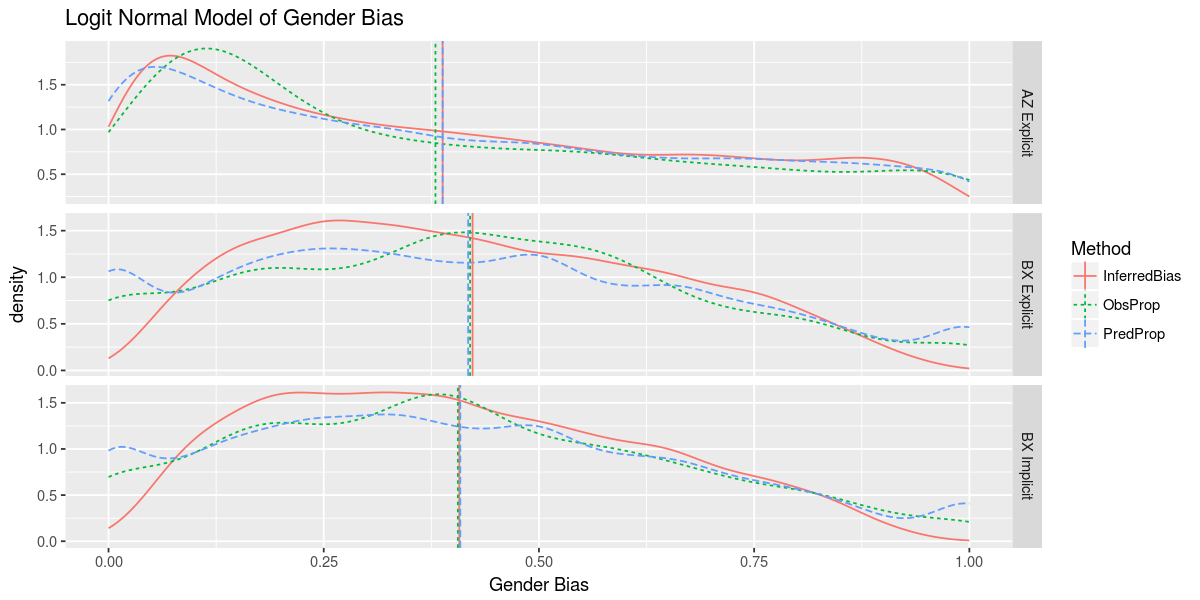

In [65]:
ggplot(ln_res_dens) +
    aes(x=value, y=density, color=Method, linetype=Method) +
    geom_line() +
    geom_vline(mapping=aes(xintercept=Mean, color=Method, linetype=Method), data=ln_means) +
    facet_grid(Set ~ ., scales = 'free') +
    xlab("Gender Bias") +
    ggtitle("Logit Normal Model of Gender Bias")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 938 rows containing non-finite values (stat_bin).”

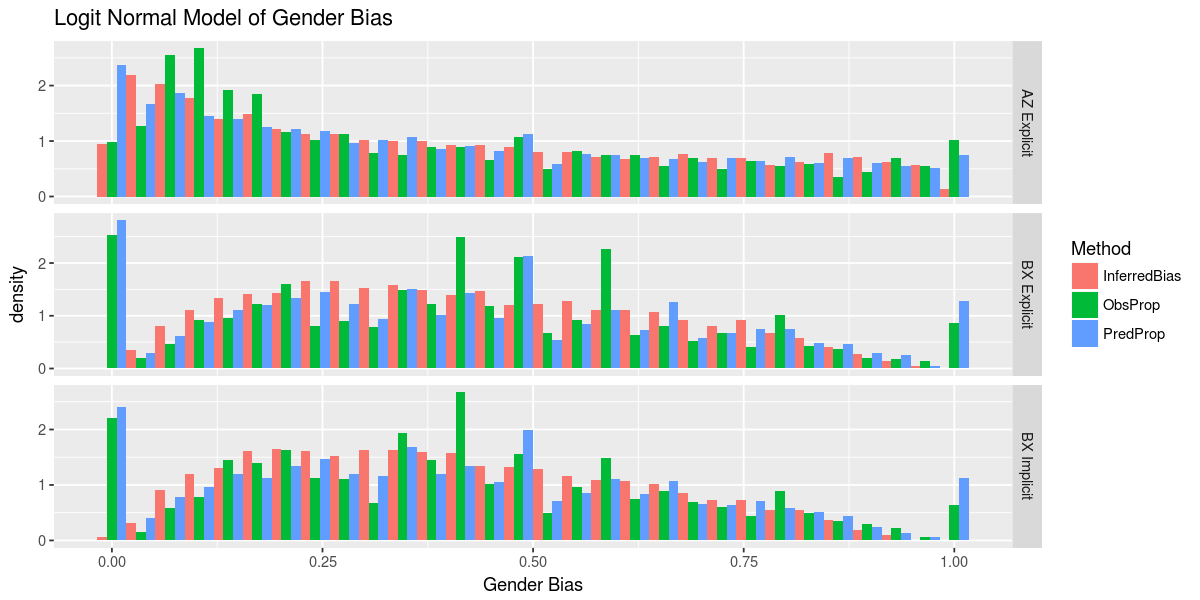

In [66]:
ggplot(ln_res) +
    aes(x=Value, fill=Method) +
    geom_histogram(position='dodge', mapping=aes(y=..density..)) +
    facet_grid(Set ~ ., scales = 'free') +
    xlab("Gender Bias") +
    ggtitle("Logit Normal Model of Gender Bias")

How do profile sizes fit?

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

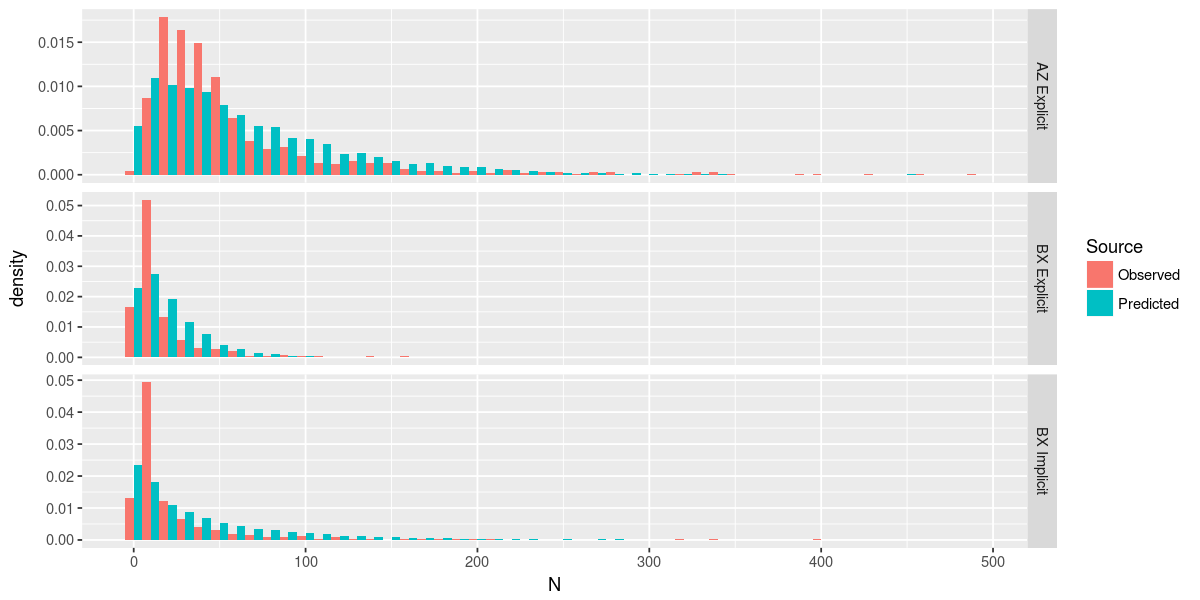

In [67]:
ln_sizes =
    bind_rows(Predicted=select(ln_sims, Set, N),
              Observed=select(profile_info, Set, N=known),
              .id="Source")
ggplot(ln_sizes %>% filter(N <= 500)) +
    aes(x=N, fill=Source) +
    geom_histogram(position='dodge', binwidth=10, mapping=aes(y=..density..)) +
    facet_grid(Set ~ ., scales = 'free')

Save some files

    save.image("ProfileModels.rda")

    load("ProfileModels.rda")

In [68]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2984686,159.4,5684620,303.6,5684620,303.6
Vcells,226476887,1727.9,327731760,2500.4,327731388,2500.4


In [69]:
data_frame(Name=ls(envir=.GlobalEnv)) %>%
    rowwise() %>%
    mutate(Size=as.numeric(object.size(.GlobalEnv[[Name]])) / 1024) %>%
    ungroup() %>%
    arrange(-Size) %>%
    mutate(CumSize=cumsum(Size))

Name,Size,CumSize
ln_fits,762700.758,762700.8
beta_nb_fits,385082.133,1147782.9
beta_fits,384696.078,1532479.0
author_gender,109955.344,1642434.3
az_item_stats,44929.680,1687364.0
user_books,10196.414,1697560.4
bx_item_stats,5932.727,1703493.1
user_ratings,5395.617,1708888.8
beta_nb_sims,1783.195,1710671.9
ln_sims,1783.195,1712455.1


## Compare Models

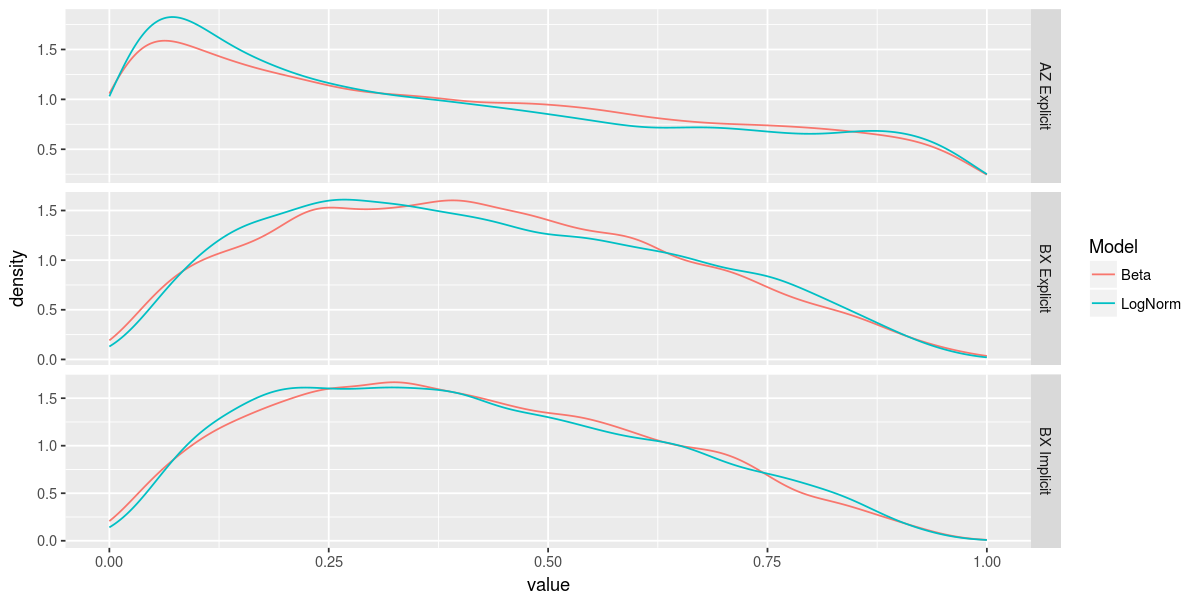

In [70]:
df = bind_rows(Beta=beta_nb_sims %>% group_by(Set) %>% 
                   summarize(dens=list(density_frame(Theta, from=0, to=1))),
              LogNorm=ln_sims %>% group_by(Set) %>% 
                   summarize(dens=list(density_frame(Theta, from=0, to=1))),
              .id="Model") %>%
    unnest(dens)
ggplot(df) +
    aes(x=value, y=density, color=Model) +
    geom_line() +
    facet_grid(Set ~ ., scales="free_y")

Joining, by = "Set"
Joining, by = "Set"
Warning message:
“Removed 2 rows containing missing values (geom_path).”

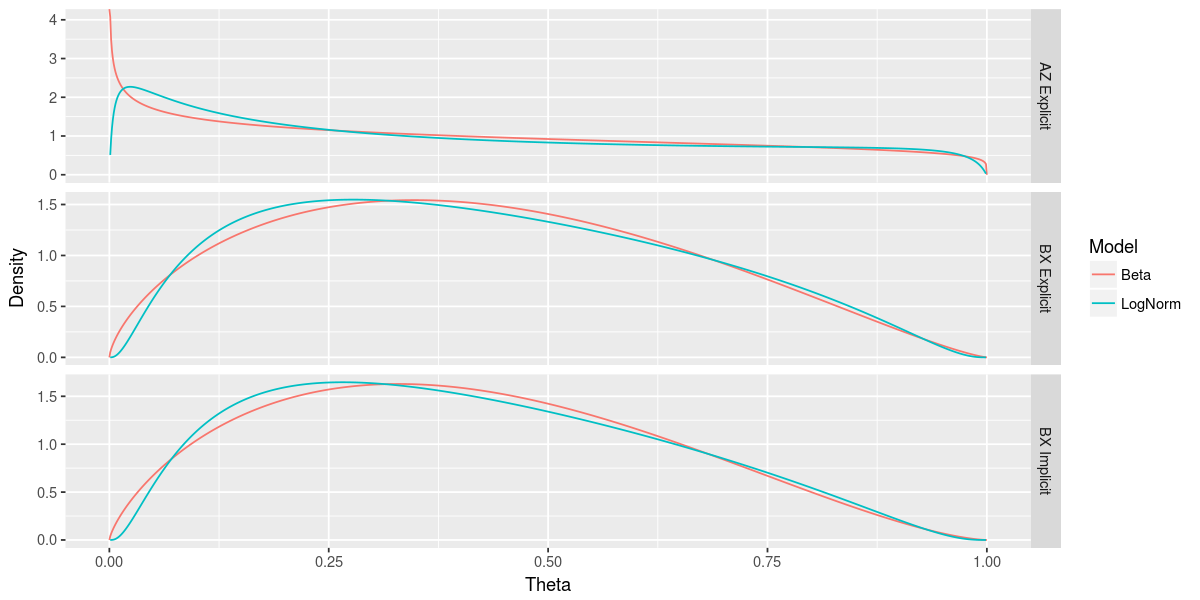

In [71]:
ln_stats = ln_sims %>% group_by(Set) %>% summarize(Mu=mean(Mu), 
                                                   Sigma=mean(Sigma))
beta_stats = beta_nb_sims %>% group_by(Set) %>% summarize(Alpha=mean(Alpha), Beta=mean(Beta))
df = crossing(Set=unique(ln_stats$Set), Theta=seq(0,1,0.001)) %>%
    inner_join(ln_stats) %>%
    inner_join(beta_stats) %>%
    transmute(Set=Set, Theta=Theta,
              Beta=dbeta(Theta, Alpha, Beta),
              LogNorm=dnorm(log(Theta) - log(1 - Theta), Mu, Sigma) / (Theta * (1-Theta))) %>%
    gather("Model", "Density", Beta, LogNorm)
ggplot(df) +
    aes(x=Theta, y=Density, color=Model) +
    geom_line() +
    facet_grid(Set ~ ., scales="free_y")

We get too many misfits when using LOO on the raw likelihoods. Googling indicates that this can be an artifact of having per-data-point parameters. So we will compute log likelihoods using fewer parameters - for each sample, we will take its 'true' parameters, and we will average over a range of $\theta$ values instead of using the single sample $\theta$.

In [72]:
beta_llmat = function(data, sims, thetas=seq(0, 1, 0.01)) {   
    message("computing theta matrix")
    pym = crossing(userID=data$userID, theta=thetas) %>%
        inner_join(select(data, userID, N=known, Y=NFemale)) %>%
        mutate(pY = dbinom(Y, N, theta)) %>%
        select(theta, userID, pY) %>%
        spread(userID, pY)
    see_if(are_equal(nrow(pym), length(thetas)))
    
    # make data structure
    thetas = pym$theta
    pym = pym %>% select(-theta) %>% as.matrix()
    see_if(are_equal(dim(pym), c(length(thetas), length(data))))
    ns = data %>% arrange(userID) %>% pull(known)
    assert_that(noNA(ns))
    
    message("computing simulation likelihoods")
    foreach(Alpha=sims$Alpha, Beta=sims$Beta, NRate=sims$NRate,
            .combine=rbind) %dopar% {
        psz = dpois(ns, NRate)
        pth = dbeta(thetas, Alpha, Beta)
        # rescale each row of pY by pTH
        pyth = pym * pth
        # factor in the probability of size by column, transposing
        prob = t(pyth) * psz
        nas = sum(is.na(prob))
        # users are now on rows, so take their means
        log(rowMeans(prob))
    }
}

In [73]:
beta_nb_llmat = function(data, sims, thetas=seq(0.01, 0.99, 0.01)) {   
    message("computing theta matrix")
    pym = crossing(userID=data$userID, theta=thetas) %>%
        inner_join(select(data, userID, N=known, Y=NFemale)) %>%
        mutate(pY = dbinom(Y, N, theta)) %>%
        select(theta, userID, pY) %>%
        spread(userID, pY)
    see_if(are_equal(nrow(pym), length(thetas)))
    
    # make data structure
    thetas = pym$theta
    pym = pym %>% select(-theta) %>% as.matrix()
    see_if(are_equal(dim(pym), c(length(thetas), length(data))))
    see_if(are_equal(as.integer(colnames(pym)), arrange(data, userID)$userID))
    ns = data %>% arrange(userID) %>% pull(known)
    assert_that(noNA(ns))
    
    message("computing simulation likelihoods")
    foreach(Alpha=sims$Alpha, Beta=sims$Beta, NMu=sims$NMu, NDisp=sims$NDisp,
            .combine=rbind) %dopar% {
        psz = dnbinom(ns, size=NDisp, mu=NMu)
        pth = dbeta(thetas, Alpha, Beta)
        # rescale each row of pY by pTH
        pyth = pym * pth
        # factor in the probability of size by column, transposing
        prob = t(pyth) * psz
        # users are now on rows, so take their means
        log(rowMeans(prob))
    }
}

In [74]:
ln_llmat = function(data, sims, thetas=seq(0.01, 0.99, 0.01)) {
    message("computing theta matrix")
    pym = crossing(userID=data$userID, theta=thetas) %>%
        inner_join(select(data, userID, N=known, Y=NFemale)) %>%
        mutate(pY = dbinom(Y, N, theta)) %>%
        select(theta, userID, pY) %>%
        spread(userID, pY)
    see_if(are_equal(nrow(pym), length(thetas)))
    
    # make data structure
    thetas = pym$theta
    pym = pym %>% select(-theta) %>% as.matrix()
    see_if(are_equal(dim(pym), c(length(thetas), length(data))))
    see_if(are_equal(as.integer(colnames(pym)), arrange(data, userID)$userID))
    ns = data %>% arrange(userID) %>% pull(known)
    assert_that(noNA(ns))
    
    message("computing simulation likelihoods")
    foreach(Mu=sims$Mu, Sigma=sims$Sigma, NMu=sims$NMu, NDisp=sims$NDisp,
            .combine=rbind) %dopar% {
        psz = dnbinom(ns, size=NDisp, mu=NMu)
        pth = dnorm(log(thetas) - log(1 - thetas), Mu, Sigma) / (thetas * (1 - thetas))
        # rescale each row of pY by pTH
        pyth = pym * pth
        # factor in the probability of size by column, transposing
        prob = t(pyth) * psz
        # users are now on rows, so take their means
        log(rowMeans(prob))
    }
}

In [75]:
compute_llmat = function(set, sim, func) {
    data = profile_info %>% filter(Set == set)
    sims = sim %>% filter(Set == set)
    message("using ", nrow(data), " data points and ", nrow(sims), " simulations")
    func(data, sims)
}

### Compute LL matrices for models

We do not test on the Beta-Poisson, because they produce too many infinite improbabilities. Which suggests they are a poor fit anyway. Like Zaphod Beeblebrox's clothes.

Beta-NB explicit:

In [76]:
beta_implicit_ll = compute_llmat('BX Implicit', beta_nb_sims, beta_nb_llmat)
dim(beta_implicit_ll)

using 1000 data points and 8000 simulations
computing theta matrix
Joining, by = "userID"
computing simulation likelihoods


[1] 8000 1000

In [77]:
summary(as.vector(beta_implicit_ll))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-84.762  -7.886  -6.526  -7.389  -5.764  -4.807 

In [78]:
beta_implicit_loo = loo(beta_implicit_ll)
print(beta_implicit_loo)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.”

Computed from 8000 by 1000 log-likelihood matrix

         Estimate    SE
elpd_loo  -7400.4 116.3
p_loo        20.2  10.3
looic     14800.7 232.7

Pareto k diagnostic values:
                         Count  Pct 
(-Inf, 0.5]   (good)     998   99.8%
 (0.5, 0.7]   (ok)         0    0.0%
   (0.7, 1]   (bad)        1    0.1%
   (1, Inf)   (very bad)   1    0.1%
See help('pareto-k-diagnostic') for details.

Beta-NB explicit:

In [79]:
beta_explicit_ll = compute_llmat('BX Explicit', beta_nb_sims, beta_nb_llmat)

using 1000 data points and 8000 simulations
computing theta matrix
Joining, by = "userID"
computing simulation likelihoods


In [80]:
beta_explicit_loo = loo(beta_explicit_ll)
print(beta_explicit_loo)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.”

Computed from 8000 by 1000 log-likelihood matrix

         Estimate    SE
elpd_loo  -6580.7  86.1
p_loo         9.7   2.7
looic     13161.3 172.2

Pareto k diagnostic values:
                         Count  Pct 
(-Inf, 0.5]   (good)     999   99.9%
 (0.5, 0.7]   (ok)         1    0.1%
   (0.7, 1]   (bad)        0    0.0%
   (1, Inf)   (very bad)   0    0.0%

All Pareto k estimates are ok (k < 0.7)
See help('pareto-k-diagnostic') for details.

Logit-Normal implicit:

In [ ]:
ln_implicit_ll = compute_llmat('BX Implicit', ln_sims, ln_llmat)

using 1000 data points and 8000 simulations
computing theta matrix
Joining, by = "userID"
computing simulation likelihoods


In [ ]:
summary(as.vector(ln_implicit_ll))

In [ ]:
ln_implicit_loo = loo(ln_implicit_ll)
print(ln_implicit_loo)

Logit-Normal explicit:

In [ ]:
ln_explicit_ll = compute_llmat('BX Explicit', ln_sims, ln_llmat)

In [ ]:
ln_explicit_loo = loo(ln_explicit_ll)
print(ln_explicit_loo)

### Compare Models
Now, let us compare the implicit models:

In [ ]:
implicit_cmp = compare(beta_implicit_loo, ln_implicit_loo)
print(implicit_cmp)

In [ ]:
explicit_cmp = compare(beta_explicit_loo, ln_explicit_loo)
print(explicit_cmp)